In [1]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

#Updating settings
pd.options.display.max_columns = None

# Loading the dataset
data = pd.read_csv('fake_job_postings.csv')

### Looking at the summary of the data

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [3]:
data.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
data.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

The data has lot of text columns. However, some of these columns can be converted into categorical columns. We take a look at these individually.

In [5]:
description_columns = ['department', 'company_profile', 'description', 'requirements', 'benefits'] ##Converted to flag variable
other_columns = ['title', #dropped
                     'location', # Split into country, state, city
                     'salary_range',
                'industry',] #drop
category_columns = ['employment_type', 'required_experience', 'required_education', 'function']

For the columns classified as description type, we engineer a flag feature indicating whether or not the field has been provided. Hence it will be 0 if the row is NaN and 1 otherwise

In [6]:
for column in description_columns:
    column_name = 'has_' + column
    data[column_name] = np.where((data[column]).isna(), 0, 1)

    
data[['Country', 'State', 'City']] = data['location'].str.split(',', expand = True, n = 2)
## Location might be highly unregularized/Have multiple locations

retained_industries =  data.groupby('industry') \
                      .agg(industry_count = pd.NamedAgg('job_id','count')) \
                      .sort_values('industry_count', ascending = False) \
                      .head(12).reset_index()

data = data.merge(retained_industries, how = 'left', on = 'industry')

data['industry_'] = np.where((~data['industry'].isna()) & (data['industry_count'].isna()), 'Other', data['industry'])
data['mulitple_locations'] = np.where(
                                (data['City'].str.contains('/', case = False, regex = False)) & (~data['City'].isna()),
                                 1, 0)

#If City is NaN, we put multiple locations as 0

##As there are too many industries, cities and states, it will difficult to OHE all of them. Hence, we 
##will retain only those which have a sufficiently large count and bucket the rest into 'Others' 
##  - Need to select how many to bucket
## May want to do same with function ~not sure

Text(0, 0.5, 'Count of Industry')

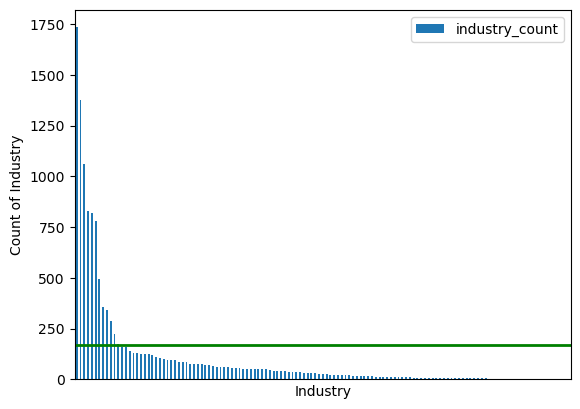

In [7]:
retained_industries =  data.groupby('industry') \
                      .agg(industry_count = pd.NamedAgg('job_id','count')) \
                      .sort_values('industry_count', ascending = False)

bar_plot = retained_industries.plot.bar()
bar_plot.axhline(y=170, color= 'green', linewidth=2)
bar_plot.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

bar_plot.set_xlabel('Industry')
bar_plot.set_ylabel('Count of Industry')

In [8]:
data = data.drop(['company_profile', 'description', 'requirements', 'benefits', 'department', #Converted to flag
                  'location', 'City', 'State', #Extracted city,state,country
                  'industry_count', #Count columns
                  'job_id', #index
                  'title', 'salary_range'], #Dropped
                axis = 1)

data

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_department,has_company_profile,has_description,has_requirements,has_benefits,Country,industry_,mulitple_locations
0,0,1,0,Other,Internship,NaN,NaN,Marketing,0,1,1,1,1,0,US,NaN,0
1,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,1,1,1,1,1,NZ,Marketing and Advertising,0
2,0,1,0,NaN,NaN,NaN,NaN,NaN,0,0,1,1,1,0,US,NaN,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,1,1,1,1,1,US,Computer Software,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0,1,1,1,1,US,Hospital & Health Care,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0,1,1,1,1,1,CA,Computer Software,0
17876,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,1,1,1,1,1,US,Internet,0
17877,0,0,0,Full-time,NaN,NaN,NaN,NaN,0,0,1,1,1,0,US,NaN,0
17878,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,0,0,1,1,1,NG,Other,0


In [9]:
data.describe()

,telecommuting,has_company_logo,has_questions,fraudulent,has_department,has_company_profile,has_description,has_requirements,has_benefits,mulitple_locations
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434,0.354195,0.814989,0.999944,0.849273,0.596756,0.004083
std,0.202631,0.403492,0.499945,0.214688,0.478282,0.388317,0.007479,0.357793,0.490563,0.063768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='fraudulent'>

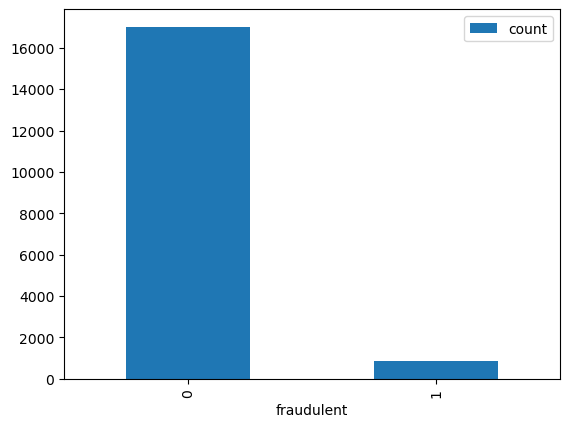

In [13]:
plot = data.groupby('fraudulent').agg(count = pd.NamedAgg('telecommuting', 'count')).reset_index().plot.bar(x = 'fraudulent', y = 'count')
plot.set_xlabel

In [ ]:
data.to_csv('./fake_job_postings_final_v2.csv', index=False)